# Model Training

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [ ]:
start_run(config_file=Path('config.yml'))

2025-02-14 14:58:41,059: Logging to c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-Z_score_test_1402_145841\output.log initialized.
2025-02-14 14:58:41,059: ### Folder structure created at c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-Z_score_test_1402_145841
2025-02-14 14:58:41,060: ### Run configurations for GAGEii-Z_score_test
2025-02-14 14:58:41,061: experiment_name: GAGEii-Z_score_test
2025-02-14 14:58:41,061: run_dir: c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-Z_score_test_1402_145841
2025-02-14 14:58:41,061: train_basin_file: basin_list\train.txt
2025-02-14 14:58:41,062: validation_basin_file: basin_list\train.txt
2025-02-14 14:58:41,062: test_basin_file: basin_list\train.txt
2025-02-14 14:58:41,062: train_start_date: 1981-01-01 00:00:00
2025-02-14 14:58:41,063: train_end_date: 2000-12-31 00:00:00
2025-02-14 14:58:41,063: validation_start_date: 2001-01-01 00:00:00
2025-02-14 14:58:41,063: validation_end_date: 2010-12-31 00:00:

# Evaluation

In [33]:
run_dir = Path("runs/GAGEii-Z_score_test_1402_141421") 
eval_run(run_dir=run_dir, period="test")

with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)

2025-02-14 14:52:41,732: Using the model weights from runs\GAGEii-Z_score_test_1402_141421\model_epoch050.pt


C:\Users\ybrot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub f

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
2025-02-14 14:52:42,463: Stored metrics at runs\GAGEii-Z_score_test_1402_141421\test\model_epoch050\test_metrics.csv
2025-02-14 14:52:42,465: Stored results at runs\GAGEii-Z_score_test_1402_141421\test\model_epoch050\test_results.p


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `results` is already loaded with subbasin data.

# Extract subbasin keys
subbasin_keys = list(results.keys())

# Initialize lists to store NSE values and subbasin IDs
nse_values = []
subbasin_ids = []

# Loop through each subbasin and collect NSE values
for key in subbasin_keys:
    
    if 'NSE' not in results[key]['1D']:
        print(f"Skipping {key} as it does not have 1D results.")
        continue
    
    nse = results[key]['1D']['NSE']
    nse_values.append(nse)
    subbasin_ids.append(key)

# Convert to a DataFrame for easier manipulation and visualization
nse_df = pd.DataFrame({'Subbasin': subbasin_ids, 'NSE': nse_values})

# Statistical Summary
summary_stats = nse_df['NSE'].describe()


In [13]:
summary_stats   

count           1.0
mean    -14820239.0
std             NaN
min     -14820239.0
25%     -14820239.0
50%     -14820239.0
75%     -14820239.0
max     -14820239.0
Name: NSE, dtype: float64

In [14]:
nse_df['Performance'] = nse_df['NSE'].apply(lambda x: 'Excellent' if x > 0.75 else 'Good' if x >= 0.36 else 'Unsatisfactory' if x >= 0 else 'Negative')
nse_df['Performance'].value_counts()

Performance
Negative    1
Name: count, dtype: int64

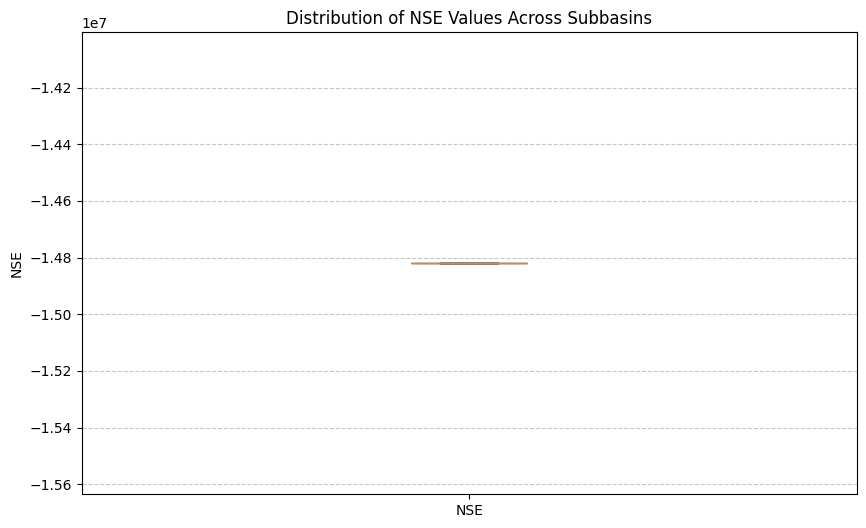

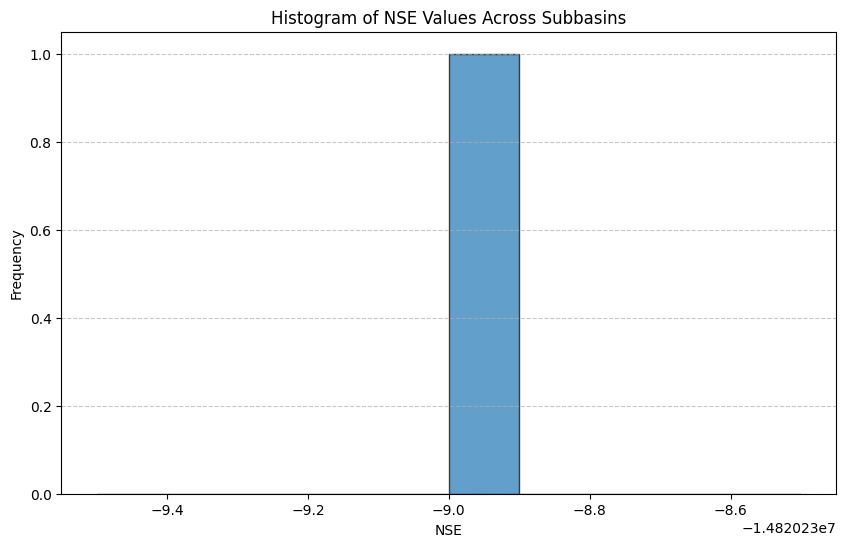

In [15]:

# Plot: Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(nse_df['NSE'], vert=True, patch_artist=True, labels=['NSE'])
plt.title("Distribution of NSE Values Across Subbasins")
plt.ylabel("NSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot: Histogram
plt.figure(figsize=(10, 6))
plt.hist(nse_df['NSE'], bins=10, edgecolor='black', alpha=0.7)
plt.title("Histogram of NSE Values Across Subbasins")
plt.xlabel("NSE")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

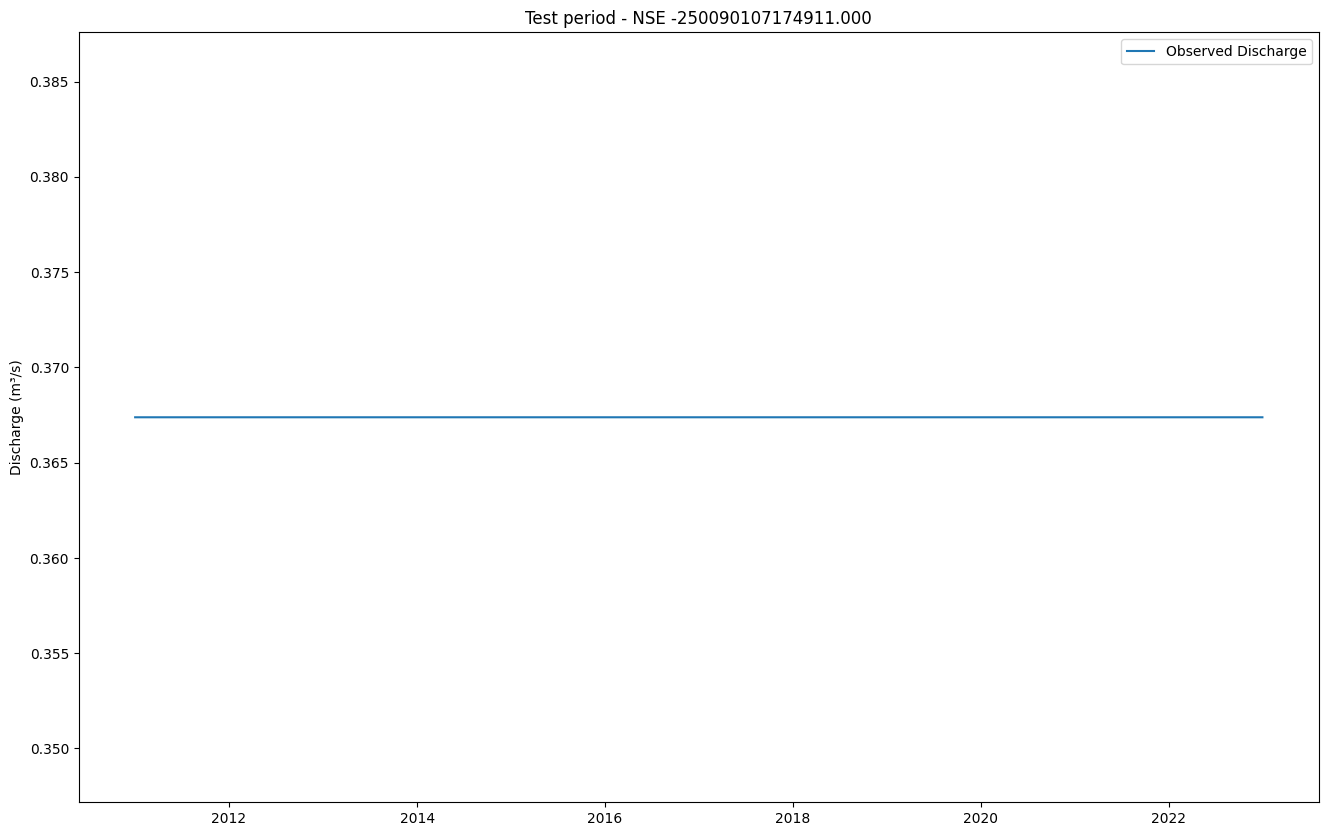

In [ ]:
# extract observations and simulations
qobs = results['02AA001']['1D']['xr']['discharge_obs']
qsim = results['02AA001']['1D']['xr']['discharge_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs, label='Observed Discharge')
ax.plot(qsim['date'], qsim, label='Simulated Discharge')
ax.set_ylabel("Discharge (m³/s)")
ax.set_title(f"Test period - NSE {results['02AA001']['1D']['NSE']:.3f}")
ax.legend()  # Add legend to indicate which line is which

# Evaluation after inverse-transforming the predictions

In [46]:
def evaluate_basin_prediction(basin_id: str, run_dir: str, epoch_num: int, 
                              csv_dir: str = "data/csv_files",
                              test_start_date: str = '01/01/2011',
                              test_end_date: str = '31/12/2022',
                              draw_graph: bool = True) -> float:
    
    run_dir = Path("runs/"+run_dir) 
    eval_run(run_dir=run_dir, period="test")
    
    # set the epoch number
    epoch_num = str(epoch_num)
    if len(epoch_num) == 1:
        epoch_num = "model_epoch00" + epoch_num
    elif len(epoch_num) == 2:
        epoch_num = "model_epoch0" + epoch_num
    else:
        epoch_num = "model_epoch" + epoch_num
    
    # evaluation
    with open(run_dir / "test" / epoch_num / "test_results.p", "rb") as fp:
        results = pickle.load(fp)
        
    # simulated values
    qsim = results[basin_id]['1D']['xr']['discharge_sim']
    qsim_values = qsim.values
    
    # invert the standardization
    mean = 0.8561527661255196
    var = 5.06157279557463
    
    inverted_qsim_values = (qsim_values * np.sqrt(var)) + mean
    
    # Invert the log transformation
    inverted_qsim_values = np.exp(inverted_qsim_values) - 1e-6
    
    # Read the CSV file as a dataframe
    csv_file_path = Path(csv_dir) / f"{basin_id}.csv"
    df = pd.read_csv(csv_file_path, index_col='date', parse_dates=True)
    
    # Filter the dataframe for the specified date range and select the "discharge" column
    df_filtered = df.loc[test_start_date:test_end_date, ['discharge']]
    
    # Calculate NSE
    observed_values = df_filtered['discharge'].values
    simulated_values = inverted_qsim_values[:len(observed_values)]  # Ensure the lengths match
    
    mean_observed = np.mean(observed_values)
    nse = 1 - (np.sum((observed_values - simulated_values) ** 2) / np.sum((observed_values - mean_observed) ** 2))
    
    if draw_graph:
        fig, ax = plt.subplots(figsize=(16,10))
        ax.plot(qsim['date'], observed_values, label='Observed Discharge')
        # ax.plot(qsim['date'], inverted_qsim_values, label='Simulated Discharge')
        ax.set_ylabel("Discharge (m³/s)")
        ax.set_title(f"Test period - NSE {nse:.3f}")
        ax.legend()
    
    return nse
    
    

2025-02-14 14:57:55,082: Using the model weights from runs\GAGEii-Z_score_test_1402_141421\model_epoch050.pt


C:\Users\ybrot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub f

  0%|          | 0/1 [00:00<?, ?it/s]

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2025-02-14 14:57:55,808: Stored metrics at runs\GAGEii-Z_score_test_1402_141421\test\model_epoch050\test_metrics.csv
2025-02-14 14:57:55,809: Stored results at runs\GAGEii-Z_score_test_1402_141421\test\model_epoch050\test_results.p


C:\Users\ybrot\AppData\Local\Temp\ipykernel_109040\2727670421.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  nse = 1 - (np.sum((observed_values - simulated_values) ** 2) / np.sum((observed_values - mean_observed) ** 2))


-inf

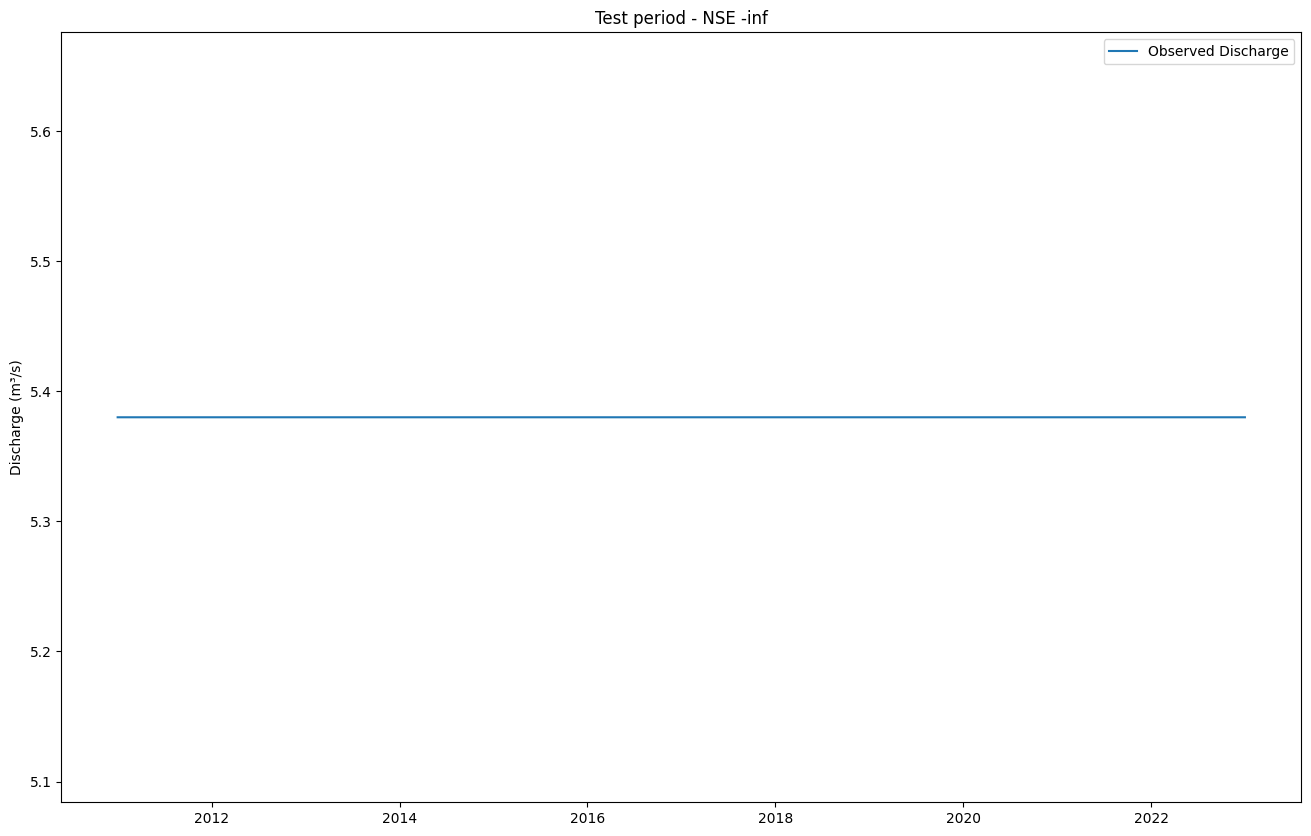

In [ ]:
evaluate_basin_prediction("02AB008", "GAGEii-Z_score_test_1402_141421", 50)

In [29]:
csv_dir: str = "data/processed_csv_files"
test_start_date: str = '01/01/2011'
test_end_date: str = '31/12/2022'
basin_id = "04025500"

# Read the CSV file as a dataframe
csv_file_path = Path(csv_dir) / f"{basin_id}.csv"
df = pd.read_csv(csv_file_path, index_col='date', parse_dates=True)

# Filter the dataframe for the specified date range and select the "discharge" column
df_filtered = df.loc[test_start_date:test_end_date, ['discharge']]